# Multiclass Support Vector Machine algorithm

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [0]:
cd/content

/content


In [0]:
!ls

google-colab-cs231n  sample_data


In [0]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

fatal: destination path 'google-colab-cs231n' already exists and is not an empty directory.


In [0]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [0]:
!pip install imageio

In [0]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
cifar-10-batches-py  get_datasets.sh


In [0]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [0]:
!./get_datasets.sh

--2019-07-18 04:31:40--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.5MB/s    in 4.0s    

2019-07-18 04:31:45 (40.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


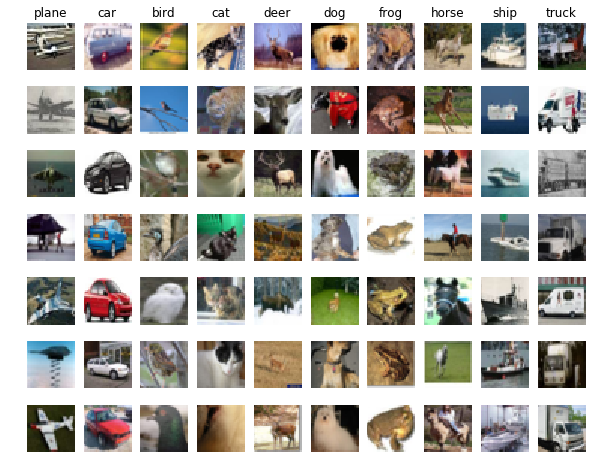

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


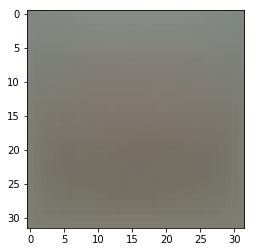

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
# Preprocessing: subtract the mean image for normalization
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Building SVM Classfier

In [0]:
# Using CS231n libary to estimate the loss: 
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print('grad: ', grad)

loss: 8.935766
grad:  [[-2.03055810e+01 -1.19943509e+01  1.48137422e+01 ... -7.69089167e+00
  -1.02091764e+01 -3.77084458e+01]
 [-3.02901827e+01 -8.88924204e+00  1.58252512e+01 ... -1.05506576e+01
  -1.85779178e+01 -4.04063288e+01]
 [-4.27252608e+01 -1.40417736e+01  2.00156425e+01 ... -9.38093894e+00
  -3.39240267e+01 -5.04674695e+01]
 ...
 [-1.96913804e+01 -1.10333868e+01  3.52857126e+00 ... -2.40896947e+00
   9.84773665e+00  1.50151527e+00]
 [-2.74920043e+01 -2.21828291e+01  5.40887628e+00 ...  2.07323846e+01
  -7.89755114e+00 -8.02807713e-01]
 [-1.00000005e-02 -6.80000009e-02  1.78000000e-01 ... -3.59999999e-02
   1.14000002e-01 -1.80000019e-02]]


In [0]:
# Building from scratch
def L_i_vectorized(x, y, W):
  scores = np.dot(x,W)
  margins = np.maximum(0, scores - scores[y] + 1)
  margins[y] = 0
  loss_i = np.sum(margins)
  return loss_i

loss_1 = 0
num_test = X_dev.shape[0]
for idx in range(num_test):
  loss_idv = L_i_vectorized(X_dev[idx], y_dev[idx], W)
  loss_1 += loss_idv
print(loss_1/num_test)

8.935766164744757


In [0]:
# naive way to calculate loss and grad to achieve (1): precise calculation
def svm_loss_naive(W, X, y, reg):
  """ calculate loss and gradient of the loss function at W. Naive way
  W: 2d numpy array of shape (d, C). The weight matrix.
  X: 2d numpy array of shape (N, d). The training data
  y: 1d numpy array of shape (N,). The training label
  reg: a positive number. The regularization parameter
  """
  d, C, N = W.shape[0], W.shape[1], X.shape[0] # data dimension, number of classes, number of points
  loss = 0
  dW = np.zeros_like(W) # (d, C)
  for n in range(N):
    xn = X[n] # size (d,) - this is 1 dimension array
    score = xn.dot(W) # size (1, C)
    for j in range(C):
      if j == y[n]:
        continue
      margin = score[j] - score[y[n]] + 1
      if margin > 0:
        loss += margin
        dW[:, j] += xn
        dW[:, y[n]] -= xn
  loss /= N
  loss += 0.5*reg*np.sum(W*W)
  dW /= N
  dW += reg*W
  return loss, dW

To optimize the loss function, we use Stochastic Gradient Method, in which gradient is calculated per iteration. At the same time, loss after each iteration is also calcuated to ensure it within the acceptable range.  <br>
Two requirements are (1): precise calculation; (2): efficient running. 

In [0]:
# more efficient way to compute loss and grad
def svm_loss_vectorized(W, X, y, reg):
  d, C = W.shape[0], W.shape[1]
  X = X.reshape(-1, d)
  N = X.shape[0]
  loss = 0
  dW = np.zeros_like(W)
  
  Z = X.dot(W) #(N,C)
  id0 = np.arange(Z.shape[0])
  correct_class_score = Z[id0, y].reshape(N,1) #(N,1)
  margins = np.maximum(0, Z - correct_class_score + 1) #(N, C)
  margins[id0, y] = 0
  loss = np.sum(margins)
  loss /=N
  loss += 0.5* reg* np.sum(W*W)
  
  F = (margins > 0).astype(int)# shape of (N, C)
  F[np.arange(F.shape[0]), y] = np.sum(-F, axis = 1)
  dW = X.T.dot(F)/N + reg*W
  return loss, dW

In [0]:
# Comparison with regards to computational time and efficiency between naive and vectorized
# With development set
import time
reg=0.1
t1 = time.time()
l1, dW1 = svm_loss_naive(W, X_dev, y_dev, reg)
t2 = time.time()
l2, dW2 = svm_loss_vectorized(W, X_dev, y_dev, reg)
t3 = time.time()
print("Naive way     --run time:", t2-t1, "s")
print("Vectorized way--run time:", t3-t2, "s")
print("Loss difference:", np.linalg.norm(l1-l2))
print("Gradient difference:", np.linalg.norm(dW1-dW2))
print(l1, l2)

Naive way     --run time: 0.09706330299377441 s
Vectorized way--run time: 0.013858318328857422 s
Loss difference: 1.7763568394002505e-15
Gradient difference: 1.2415215665620475e-11
8.935781580468971 8.935781580468973


In [0]:
# With training set
import time
reg=0.1
t4 = time.time()
l1, dW1 = svm_loss_naive(W, X_train, y_train, reg)
t5 = time.time()
l2, dW2 = svm_loss_vectorized(W, X_train, y_train, reg)
t6 = time.time()
print("Naive way     --run time:", t5-t4, "s")
print("Vectorized way--run time:", t6-t5, "s")
print("Loss difference:", np.linalg.norm(l1-l2))
print("Gradient difference:", np.linalg.norm(dW1-dW2))

Naive way     --run time: 9.105031251907349 s
Vectorized way--run time: 0.8026912212371826 s
Loss difference: 4.0323300254385686e-13
Gradient difference: 3.990072484185338e-11


## Stochastic Gradient Descent and Mini-batch gradient descent


We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [0]:
# Using Mini-batch gradient descent
def multiclass_svm_MGD(X, y, Winit, reg, lr=0.1, batch_size=100, num_iters=1000, print_every=100):
  W = Winit
  loss_history = []
  for it in range(num_iters):
    mix_ids = np.random.permutation(X.shape[0])
    n_batches = int(np.ceil(X.shape[0]/float(batch_size)))
    for ib in range(n_batches):
      ids = mix_ids[batch_size*ib: min(batch_size*(ib+1), X.shape[0])]
      X_batch = X[ids]
      y_batch = y[ids]
      lossib, dW = svm_loss_vectorized(W, X_batch, y_batch, reg)
      loss_history.append(lossib)
      W -= lr*dW
    if it % print_every == 0 and it>0:
      print("epoch", it, "/", num_iters, "loss =", loss_history[it])
  return W, loss_history

In [0]:
#Winit = W = 0.00001*np.random.randn(X_train.shape[1], 10)
#W_MGD, loss_history_MGD = multiclass_svm_MGD(X_train, y_train, Winit, reg=2.5e4, lr=1e-7, num_iters=1500)

In [0]:
# Using Stochastic gradient descent
def multiclass_svm_SGD(X, y, Winit, reg, lr=0.1, nepoches = 1500):
  W = W_old = Winit
  loss_history=[]
  ep = 0
  while ep < nepoches:
    ep += 1
    mix_ids = np.random.permutation(X.shape[0])
    for i in mix_ids:
      X_i = X[i]
      y_i = y[i]
      loss_i, dW = svm_loss_vectorized(W, X_i, y_i, reg)
      loss_history.append(loss_i)
      W -= lr*dW
      if np.linalg.norm(W - W_old)/X.shape[1]<1e-6:
        break
    W_old = W
  return W, loss_history
  

In [0]:
Winit = W = 0.00001*np.random.randn(X_train.shape[1], 10)
W_SGD, loss_history_SGD = multiclass_svm_SGD(X_train, y_train, Winit, reg=2.5e4, lr=1e-7, nepoches=1500)

## Building predict function and Estimating the accuracy

In [0]:
def multisvm_predict(W, X):
  Z = X.dot(W)
  return np.argmax(Z, axis=1)

def evaluate (W, X, y):
  y_pred = multisvm_predict(W, X)
  acc = 100*np.mean(y_pred==y) #counting the number of True value over the total data points
  return acc

## Using Validation Set to choose the most appropriate model parameters

There are two parameters in the optimized multi-class SVM algorithm: regularization and learning rate. These could be found based on predefined pairs of value. Of those which give the highest precision of model on validation test will be chosen to evaluate the testing on the test set. 

In [0]:

#For MGD
lrs = [1e-9, 1e-8, 1e-7, 1e-6]
regs = [0.1, 0.01, 0.001, 0.0001]
best_W = 0
best_acc = 0
for lr in lrs:
  for reg in regs:
    W_try, loss_history_try = multiclass_svm_MGD(X_train, y_train, W, reg, lr=1e-8, num_iters=100, print_every=1e20)
    acc = evaluate(W, X_val, y_val)
    print("lr= {}, reg = {}, loss = {}, validation acc = {}".format(lr, reg, loss_history_try[-1], acc))
    if acc > best_acc:
      best_acc = acc
      best_W = W_try


lr= 1e-09, reg = 0.1, loss = 3.9214402476751253, validation acc = 40.699999999999996
lr= 1e-09, reg = 0.01, loss = 3.6905032319072175, validation acc = 40.2
lr= 1e-09, reg = 0.001, loss = 3.828801600056587, validation acc = 39.800000000000004
lr= 1e-09, reg = 0.0001, loss = 4.13168995761244, validation acc = 39.900000000000006
lr= 1e-08, reg = 0.1, loss = 3.393318493818388, validation acc = 39.6
lr= 1e-08, reg = 0.01, loss = 3.5168981497677256, validation acc = 39.6
lr= 1e-08, reg = 0.001, loss = 3.710024627390429, validation acc = 39.800000000000004
lr= 1e-08, reg = 0.0001, loss = 3.5527561679620114, validation acc = 39.4
lr= 1e-07, reg = 0.1, loss = 3.7151664017860404, validation acc = 39.4
lr= 1e-07, reg = 0.01, loss = 3.8909327978743713, validation acc = 39.0
lr= 1e-07, reg = 0.001, loss = 3.5735444568113723, validation acc = 39.2
lr= 1e-07, reg = 0.0001, loss = 3.339972201333191, validation acc = 39.5
lr= 1e-06, reg = 0.1, loss = 4.052120494461647, validation acc = 39.4
lr= 1e-06,

In [0]:
# For SGD
lrs = [1e-9, 1e-8, 1e-7, 1e-6]
regs = [0.1, 0.01, 0.001, 0.0001]
best_W = 0
best_acc = 0
for lr in lrs:
  for reg in regs:
    W_try, loss_history_try = multiclass_svm_SGD(X_train, y_train, W, reg, lr=1e-8)
    acc = evaluate(W, X_val, y_val)
    print("lr= {}, reg = {}, loss = {}, validation acc = {}".format(lr, reg, loss_history_try[-1], acc))
    if acc > best_acc:
      best_acc = acc
      best_W = W_try

lr= 1e-09, reg = 0.1, loss = 7.39374131437195, validation acc = 31.7
lr= 1e-09, reg = 0.01, loss = 1.8102837794322983, validation acc = 31.3
lr= 1e-09, reg = 0.001, loss = 10.442138995653844, validation acc = 31.8
lr= 1e-09, reg = 0.0001, loss = 2.3791098538360536, validation acc = 32.5
lr= 1e-08, reg = 0.1, loss = 1.8073541181482733, validation acc = 34.1
lr= 1e-08, reg = 0.01, loss = 2.3458711602899145, validation acc = 32.5
lr= 1e-08, reg = 0.001, loss = 1.517321780592421, validation acc = 33.0
lr= 1e-08, reg = 0.0001, loss = 5.754222093727027, validation acc = 33.300000000000004
lr= 1e-07, reg = 0.1, loss = 0.6956192798049021, validation acc = 34.300000000000004
lr= 1e-07, reg = 0.01, loss = 2.37283457813236, validation acc = 33.7
lr= 1e-07, reg = 0.001, loss = 19.826303821376346, validation acc = 32.2
lr= 1e-07, reg = 0.0001, loss = 0.09251067151480029, validation acc = 34.9
lr= 1e-06, reg = 0.1, loss = 3.6737010487992054, validation acc = 34.8
lr= 1e-06, reg = 0.01, loss = 1.6090

From results above, it can be seen that the highest validation accuracy is 42%. Now, the best W is saved under the variable best_W, which is implemented in the test tet

In [0]:
acc = evaluate(best_W, X_test, y_test)
print("Accuracy on test data = {} %".format(acc))

Accuracy on test data = 37.7 %


## Visualize the learned weights for each class

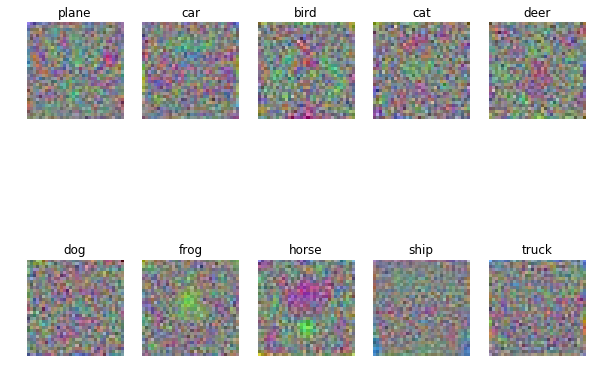

In [0]:
# Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.
w = best_W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])